# Using Secondary Student Weekly Time Allocation to Estimate Final Grade
### DSCI 100 Group Project Report - Section 006 Group 19
By: Alessandra Lu, Ruby Suo, Han Wei, Alan Wu

# Introduction

In secondary education, time management plays a pivotal role in shaping the development and outcome of students. Whether it is studying for classes, commuting to school, or socializing with friends, high school students must find balance in their hectic schedules. Academic success demands a considerable time investment from completing homework to preparing for exams. How students choose to budget their time across the various facets of their day-to-day may have long-term effects on their academic performance and overall grades.

Thus we pose the question: **How can we predict a student's final grade based on how they spend their time?**

This report seeks to explore the dynamic relationship between students' time allocation patterns and academic performance. We hope to determine how spending time on different tasks influences grades and from this understanding, predict how an average student would perform. 

We will use a data set from "Using Data Mining to Predict Secondary School Student Performance" by Paulo Cortez and Alice Silva (2008) to analyze and model how different time distributions influence a student's grade. The data illustrates the performance of Portuguese secondary school students from two schools and includes information such as student's free time, study time, final grade, and more. Researchers collected this information for Mathematics and Portuguese classes, two of the students' core courses. The original data set can be found here: https://archive.ics.uci.edu/dataset/320/student+performance

# Methods

The variables we will use for our model are:

- age
- study time
- free time
- travel time
- time out with friends

*Note: We will filter for ages 15-18 and non-zero final grades to remove outlier cases since we want to generalize for normative high school students.*

We chose these variables because of all the predictors, these allow us to quantify how students spend their time. We want to determine the trends and connections between different time distributions and what their final grades are, thus it makes sense to use parameters that are related to students schedules. 

<div class="alert alert-warning">
    TODO: (would be nice but this is not a priority) Find a source that supports our choice of KNN (namely that students influence one another so it's better to predict the data based on neighbours rather than linearly).
</div>

We will utilize a K-nearest neighbour (KNN) regression model for our analysis. We chose to use regression because all the variables analyzed are numerical thus we do not need to perform classifications. We chose KNN regression instead of linear regression because of the inherent complex and interlinked relationship between students given that they are at the same school. KNN regression allows us to better adjust for these connections given that students are generally from the same school, city, friend groups, culture, etc. It also better accounts for outliers, allowing us to get a general idea and trend without worrying about very gifted or very poorly performing students. Lastly, we are not at risk of the limitations of KNN regression, namely slow on large data sets, poor performance on many predictors, and not predicting well outside the range of training input.

## 1. Data Set Processing

In [1]:
# Import libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# Load data from the web
url <- "https://raw.githubusercontent.com/alan-w-u/dsci-100-group-project/main/student-mat.csv"
students_raw <- read_delim(url, delim = ";")
students_raw

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


<div style="color: gray;">
    Table 1.1: Complete data set.
</div>

<div class="alert alert-warning">
    TODO: Explain why we chose to select the predictors we chose USING PEER-REVIEWED SOURCES (ie how are study time, travel time, etc. are linked to final grades)
</div>

In [3]:
# Clean and wrangle the data
age_range = c(15, 16, 17, 18)

students <- students_raw |>
    filter(age %in% age_range & G3 != 0) |> # Filter for student age that is normatively in secondary school and final grade is not 0
    relocate(traveltime, .after = freetime) |> # Reorder table headers
    select(age, traveltime, studytime, freetime, goout, G3) |>
    rename(finalgrade = G3) |> # Rename G3 to be a more clear title
    mutate(finalgrade = finalgrade * 5)
students

age,traveltime,studytime,freetime,goout,finalgrade
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,2,2,3,4,30
17,1,2,3,3,30
15,1,2,3,2,50
⋮,⋮,⋮,⋮,⋮,⋮
18,1,2,3,4,40
17,2,1,4,5,80
18,3,1,4,1,50


<div style="color: gray;">
    Table 1.2: Data set with ages 15-18 and non-zero final grades.
</div>

In [4]:
# Summary table of the number of students of each age
students_count_summary <- students |>
    group_by(age) |>
    summarize(count = n())
students_count_summary

age,count
<dbl>,<int>
15,76
16,97
17,90
18,70


<div style="color: gray;">
    Table 1.3: Summary table of student data at each age.
</div>

<div class="alert alert-warning">
    TODO: (May need to change summary table) Explain a little bit about the summary table (ex: talk about imbalances)
</div>

## 2. Initial Visualization

<div class="alert alert-warning">
    TODO: Explain a little more about why we chose box plots
</div>

Now that we have our data we can create some visualization to get a big picture idea of trends. For this, we will primarily use boxplots since the five-number summary is useful for interpreting the results and since it allows us to compare the performance of different time allocations side-by-side. For our plots, we will separate the data by age to understand these trends for different grades. We will likely use a combination of the graphs above that plot study time, free time, travel time, and time out with friends and compare them.

In [5]:
# Set seed
seed <- 1
set.seed(seed)

# Split training and testing data
students_split <- initial_split(students, prop = 0.7, strata = finalgrade)
students_training <- training(students_split)
students_testing <- testing(students_split)

In [6]:
# Visualize data
options(repr.plot.height = 4, repr.plot.width = 9)

studytime_values <- c("1", "2", "3", "4")
studytime_meanings <- c("< 2", "2-5", "5-10", "> 10")

traveltime_values <- c("1", "2", "3", "4")
traveltime_meanings <- c("< 15", "15-30", "30-60", "> 60")

students_boxplot_studytime <- students_training |>
    ggplot(aes(x = as_factor(studytime), y = finalgrade)) +
    geom_boxplot() +
    labs(x = "Study Time Per Week (hours)",
         y = "Final Grade (%)",
         title = "Final Grade by Study Time") +
    scale_x_discrete(breaks = studytime_values, labels = studytime_meanings)

students_boxplot_freetime <- students_training |>
    ggplot(aes(x = as_factor(freetime), y = finalgrade)) +
    geom_boxplot() +
    labs(x = "Free Time Per Week (1 - Very Low to 5 - Very High)",
         y = "Final Grade (%)",
         title = "Final Grade by Free Time")

students_boxplot_traveltime <- students_training |>
    ggplot(aes(x = as_factor(traveltime), y = finalgrade)) +
    geom_boxplot() +
    labs(x = "Travel Time Per Week (minutes)",
         y = "Final Grade (%)",
         title = "Final Grade by Travel Time") +
    scale_x_discrete(breaks = traveltime_values, labels = traveltime_meanings)

students_boxplot_goout <- students_training |>
    ggplot(aes(x = as_factor(goout), y = finalgrade)) +
    geom_boxplot() +
    labs(x = "Time Out with Friends Per Week (1 - Very Low to 5 - Very high)",
         y = "Final Grade (%)",
         title = "Final Grade by Time Out with Friends")

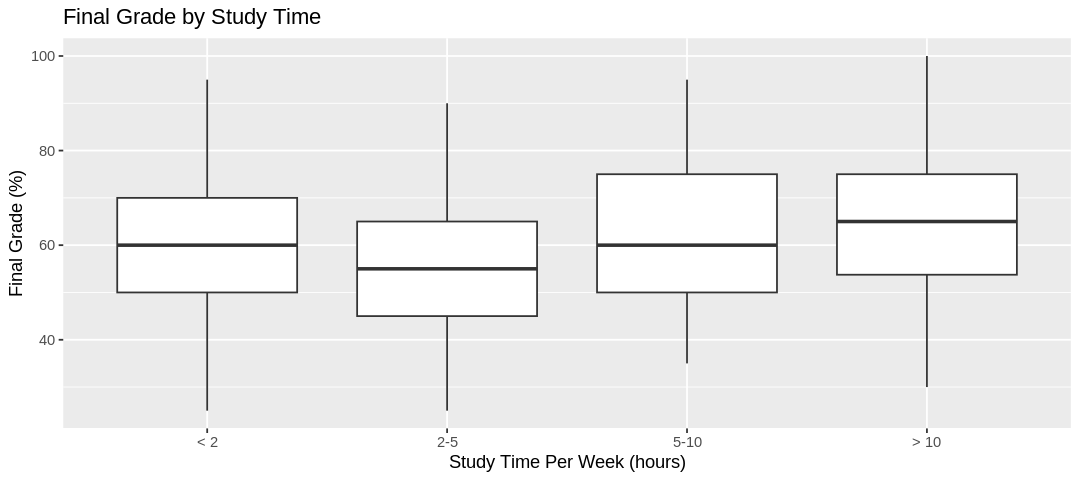

In [7]:
students_boxplot_studytime

<div style="text-align: center; color: gray;">
    Figure 2.1: Plot of final grade vs. study time.
</div>

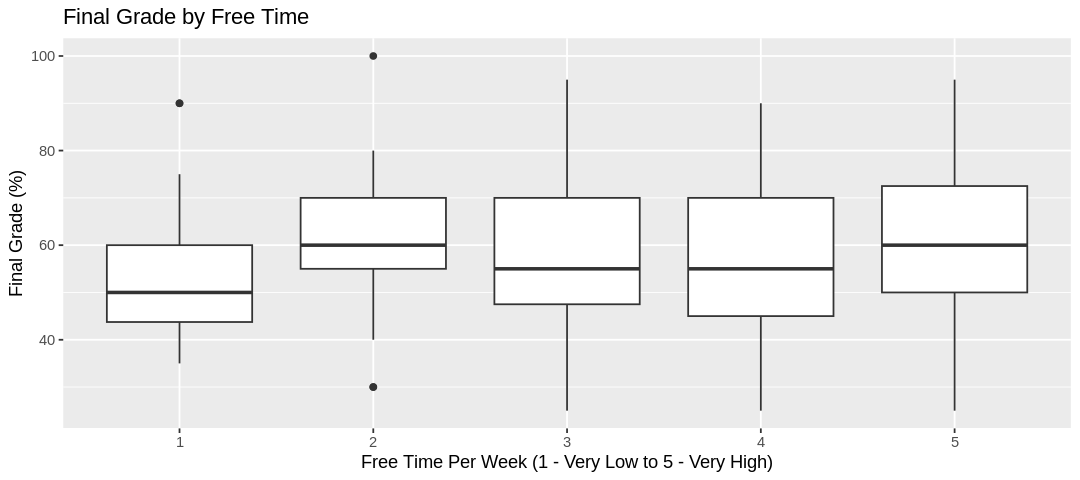

In [8]:
students_boxplot_freetime

<div style="text-align: center; color: gray;">
    Figure 2.2: Plot of final grade vs. free time.
</div>

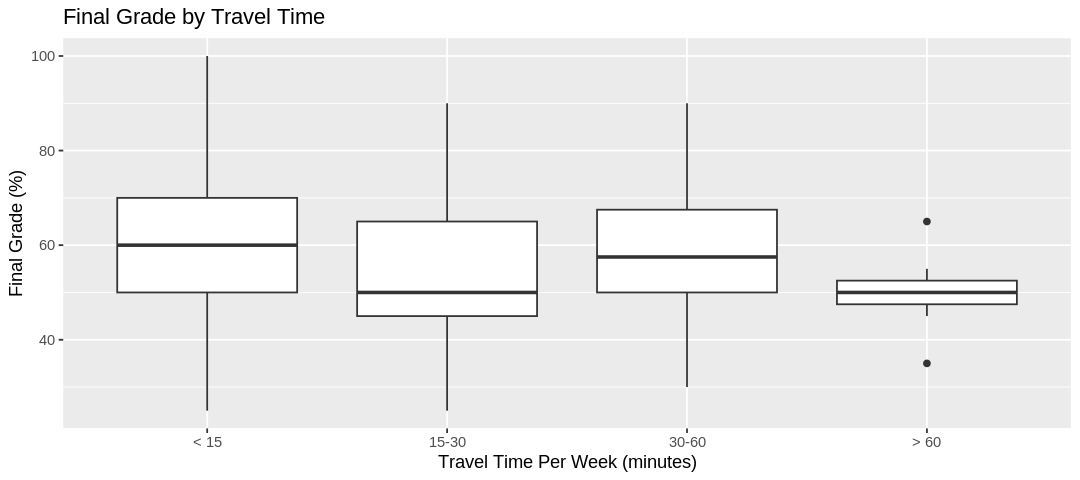

In [9]:
students_boxplot_traveltime

<div style="text-align: center; color: gray;">
    Figure 2.3: Plot of final grade vs. travel (commute) time.
</div>

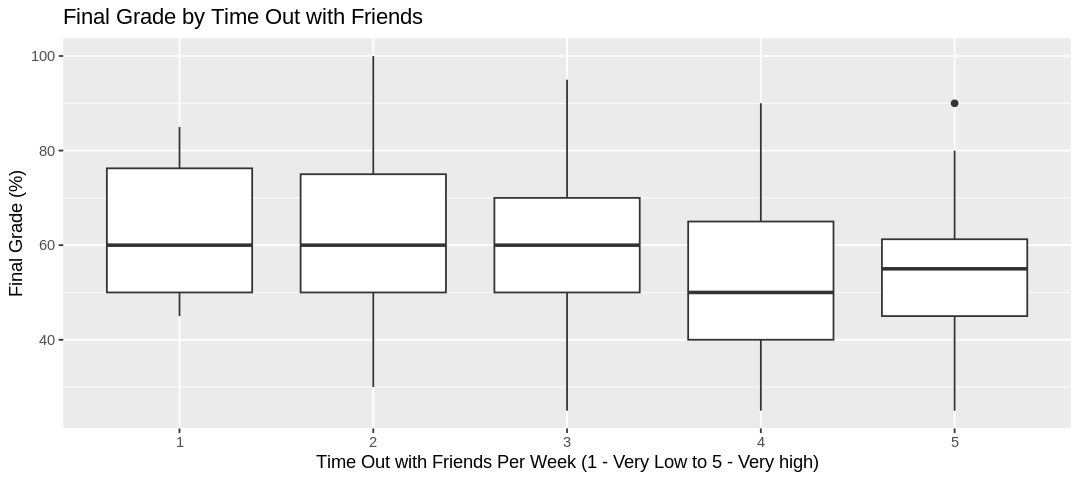

In [10]:
students_boxplot_goout

<div style="text-align: center; color: gray;">
    Figure 2.4: Plot of final grade vs. time out with friends.
</div>

<div class="alert alert-warning">
    TODO: Explain the trends we see in the box plots and how we will utilize this in the analysis
</div>

From the above box plots, we can begin to see some initial trends. Generally...

## 3. Finding K Value

To perform our KNN analysis we need to find a suitable K value to reduce underfitting and overfitting and best optimize the model's performance.

In [11]:
# Create recipes for each predictor
students_recipe_studytime <- recipe(finalgrade ~ studytime, data = students_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

students_recipe_freetime <- recipe(finalgrade ~ freetime, data = students_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

students_recipe_traveltime <- recipe(finalgrade ~ traveltime, data = students_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

students_recipe_goout <- recipe(finalgrade ~ goout, data = students_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create model
students_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Create fits for each predictor
students_tune_fit_studytime <- workflow() |>
    add_recipe(students_recipe_studytime) |>
    add_model(students_tune_spec) |>
    fit(students_training)

students_tune_fit_freetime <- workflow() |>
    add_recipe(students_recipe_freetime) |>
    add_model(students_tune_spec) |>
    fit(students_training)

students_tune_fit_traveltime <- workflow() |>
    add_recipe(students_recipe_traveltime) |>
    add_model(students_tune_spec) |>
    fit(students_training)

students_tune_fit_goout <- workflow() |>
    add_recipe(students_recipe_goout) |>
    add_model(students_tune_spec) |>
    fit(students_training)

Warning message:
“tune samples were requested but there were 231 rows in the data. 226 will be used.”
Warning message:
“tune samples were requested but there were 231 rows in the data. 226 will be used.”
Warning message:
“tune samples were requested but there were 231 rows in the data. 226 will be used.”
Warning message:
“tune samples were requested but there were 231 rows in the data. 226 will be used.”


In [12]:
set.seed(seed)

# Create a cross-validation object
students_vfold <- vfold_cv(students_training, v = 5, strata = finalgrade)

# Create a list of K values to compare against
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Run cross-validations for each predictor
students_results_studytime <- students_tune_fit_studytime |>
    tune_grid(resamples = students_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

students_results_freetime <- students_tune_fit_freetime |>
    tune_grid(resamples = students_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

students_results_traveltime <- students_tune_fit_traveltime |>
    tune_grid(resamples = students_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

students_results_goout <- students_tune_fit_goout |>
    tune_grid(resamples = students_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

In [13]:
students_results_studytime

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.76797,5,0.7667294,Preprocessor1_Model01
2,rmse,standard,25.30031,5,1.0042086,Preprocessor1_Model02
3,rmse,standard,22.92692,5,0.5758566,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,18.22431,5,0.5016900,Preprocessor1_Model48
49,rmse,standard,18.22751,5,0.4844576,Preprocessor1_Model49
50,rmse,standard,18.21607,5,0.4584010,Preprocessor1_Model50


<div style="color: gray;">
    Table 3.1: Study time RMSPE results of cross-validation from K = 1 to K = 50 with intervals of 1.
</div>

In [14]:
students_results_freetime

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,29.90151,5,0.8700975,Preprocessor1_Model01
2,rmse,standard,26.81969,5,0.3730371,Preprocessor1_Model02
3,rmse,standard,25.04801,5,0.4624163,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,17.79471,5,0.6621524,Preprocessor1_Model48
49,rmse,standard,17.72274,5,0.6685745,Preprocessor1_Model49
50,rmse,standard,17.63541,5,0.6495691,Preprocessor1_Model50


<div style="color: gray;">
    Table 3.2: Free time RMSPE results of cross-validation from K = 1 to K = 50 with intervals of 1.
</div>

In [15]:
students_results_traveltime

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.66575,5,1.9911662,Preprocessor1_Model01
2,rmse,standard,25.71415,5,0.9168385,Preprocessor1_Model02
3,rmse,standard,24.90201,5,1.2811903,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,20.94606,5,0.4182815,Preprocessor1_Model48
49,rmse,standard,20.84586,5,0.4227702,Preprocessor1_Model49
50,rmse,standard,20.67892,5,0.4089238,Preprocessor1_Model50


<div style="color: gray;">
    Table 3.3: Travel time RMSPE results of cross-validation from K = 1 to K = 50 with intervals of 1.
</div>

In [16]:
students_results_goout

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,25.88540,5,1.3384515,Preprocessor1_Model01
2,rmse,standard,24.75329,5,0.5437651,Preprocessor1_Model02
3,rmse,standard,23.47667,5,0.3463498,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,16.78994,5,0.3704672,Preprocessor1_Model48
49,rmse,standard,16.78590,5,0.3801885,Preprocessor1_Model49
50,rmse,standard,16.74665,5,0.3701186,Preprocessor1_Model50


<div style="color: gray;">
    Table 3.4: Time out with friends RMSPE results of cross-validation from K = 1 to K = 50 with intervals of 1.
</div>

From these tables we can determine which K value we should use by finding the row with the minimum RMSPE mean.

In [17]:
# Graph RMSPE against K for all predictors to visually see which has the lowest RMSPE
accuracy_plot_studytime <- students_results_studytime |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K",
         y = "RMSPE",
         title = "RMSPE by K for Study Time") +
    geom_vline(xintercept = 9, linetype = "dotted", size = 1)

accuracy_plot_freetime <- students_results_freetime |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K",
         y = "RMSPE",
         title = "RMSPE by K for Free Time") +
    geom_vline(xintercept = 6, linetype = "dotted", size = 1)

accuracy_plot_traveltime <- students_results_traveltime |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K",
         y = "RMSPE",
         title = "RMSPE by K for Travel Time") +
    geom_vline(xintercept = 8, linetype = "dotted", size = 1)

accuracy_plot_goout <- students_results_goout |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K",
         y = "RMSPE",
         title = "RMSPE by K for Time Out With Friends") +
    geom_vline(xintercept = 8, linetype = "dotted", size = 1)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


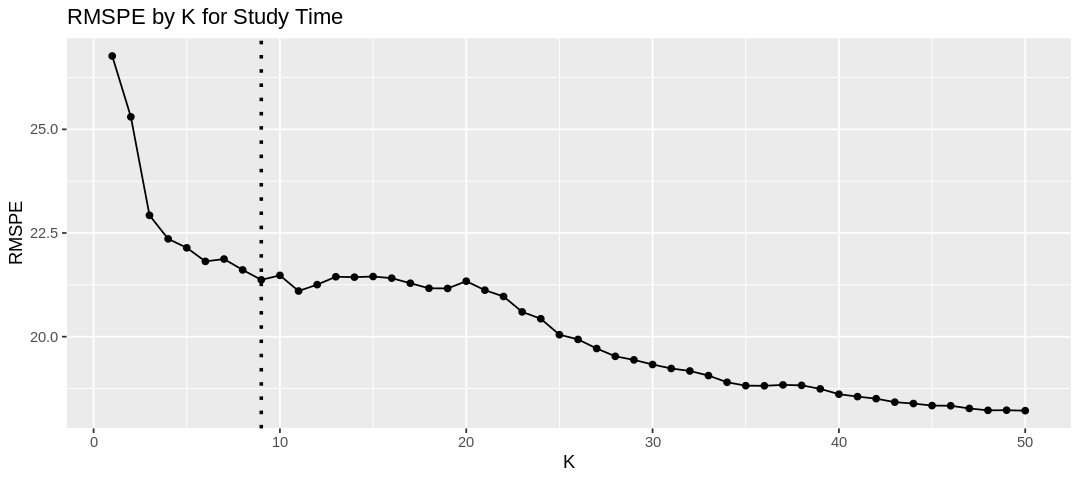

In [18]:
accuracy_plot_studytime

<div style="text-align: center; color: gray;">
    Figure 3.1: Study time plot of RMSPE vs. K.
</div>

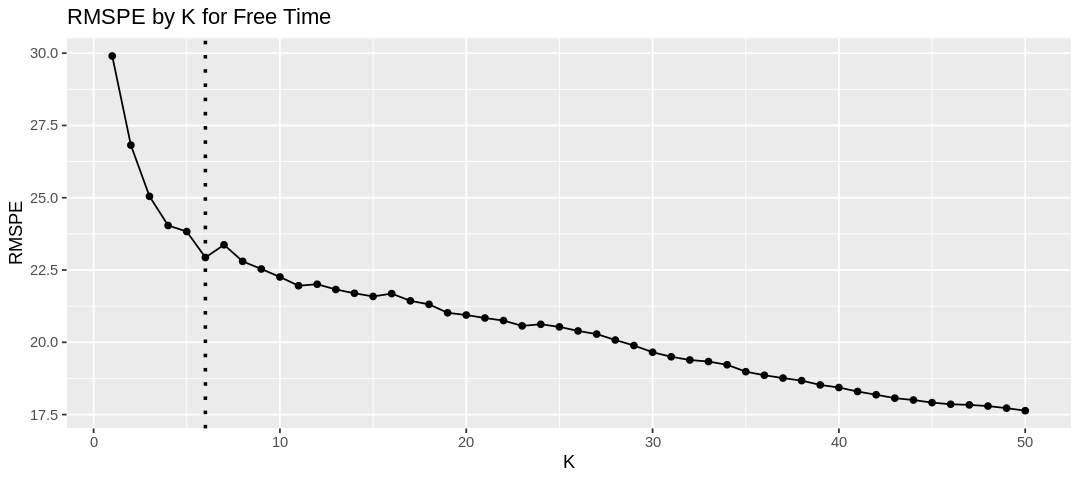

In [19]:
accuracy_plot_freetime

<div style="text-align: center; color: gray;">
    Figure 3.2: Free time plot of RMSPE vs. K.
</div>

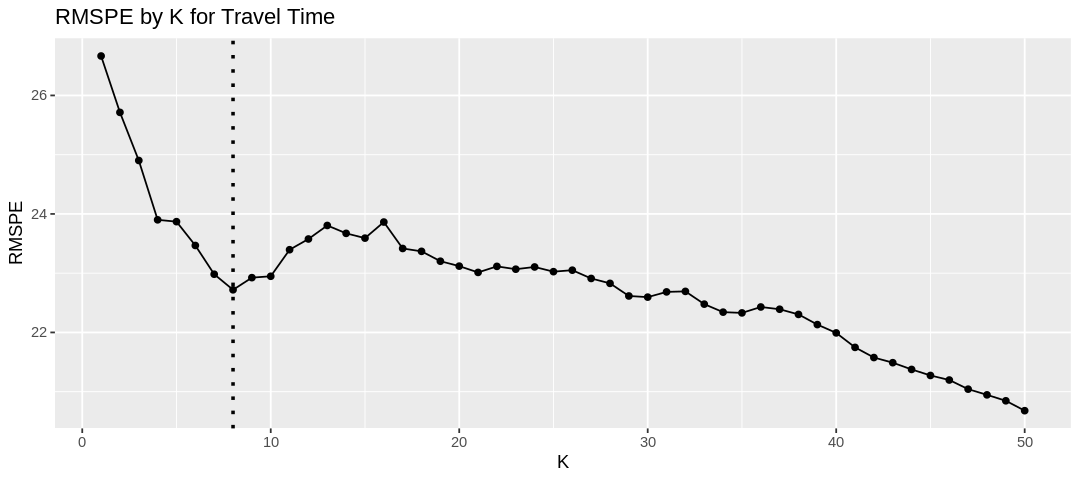

In [20]:
accuracy_plot_traveltime

<div style="text-align: center; color: gray;">
    Figure 3.3: Travel time plot of RMSPE vs. K.
</div>

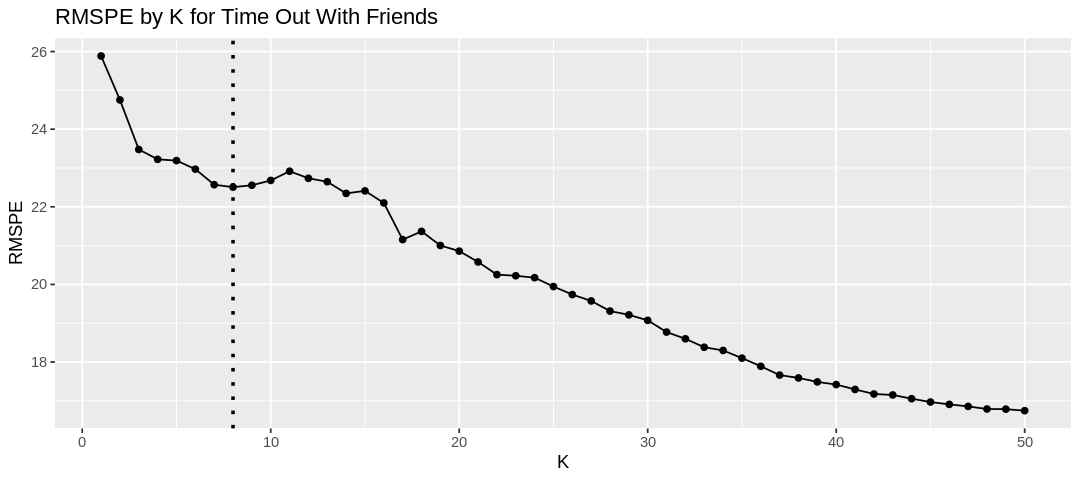

In [21]:
accuracy_plot_goout

<div style="text-align: center; color: gray;">
    Figure 3.4: Time out with friends plot of RMSPE vs. K.
</div>

In [22]:
# Find minimum RMSPE numerically to determine the best K value for each predictor
students_k_studytime <- students_results_studytime |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

students_k_freetime <- students_results_freetime |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

students_k_traveltime <- students_results_traveltime |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

students_k_goout <- students_results_goout |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

students_k_studytime
students_k_freetime
students_k_traveltime
students_k_goout

[1] 50

[1] 50

[1] 50

[1] 50

The results from the graphs and numerical analysis show differing results. Since we want to reduce underfitting, we will choose to take a smaller value than provided by the numerical analysis. Thus, we will choose the elbows of the plot.

In [23]:
# Setting K values based on results of the graph
students_k_studytime <- 9
students_k_freetime <- 6
students_k_traveltime <- 8
students_k_goout <- 8

## 4. Regression Analysis

In [24]:
# Create new models for each predictor
students_spec_studytime <- nearest_neighbor(weight_func = "rectangular", neighbors = students_k_studytime) |>
    set_engine("kknn") |>
    set_mode("regression")

students_spec_freetime <- nearest_neighbor(weight_func = "rectangular", neighbors = students_k_freetime) |>
    set_engine("kknn") |>
    set_mode("regression")

students_spec_traveltime <- nearest_neighbor(weight_func = "rectangular", neighbors = students_k_traveltime) |>
    set_engine("kknn") |>
    set_mode("regression")

students_spec_goout <- nearest_neighbor(weight_func = "rectangular", neighbors = students_k_goout) |>
    set_engine("kknn") |>
    set_mode("regression")

# Create new fits for each predictor
students_fit_studytime <- workflow() |>
    add_recipe(students_recipe_studytime) |>
    add_model(students_spec_studytime) |>
    fit(students_training)

students_fit_freetime <- workflow() |>
    add_recipe(students_recipe_freetime) |>
    add_model(students_spec_freetime) |>
    fit(students_training)

students_fit_traveltime <- workflow() |>
    add_recipe(students_recipe_traveltime) |>
    add_model(students_spec_traveltime) |>
    fit(students_training)

students_fit_goout <- workflow() |>
    add_recipe(students_recipe_goout) |>
    add_model(students_spec_goout) |>
    fit(students_training)

# Create the predictions for each predictor
students_prediction_studytime <- students_fit_studytime |>
    predict(students_testing) |>
    bind_cols(students_testing)

students_prediction_freetime <- students_fit_freetime |>
    predict(students_testing) |>
    bind_cols(students_testing)

students_prediction_traveltime <- students_fit_freetime |>
    predict(students_testing) |>
    bind_cols(students_testing)

students_prediction_goout <- students_fit_goout |>
    predict(students_testing) |>
    bind_cols(students_testing)

# Create summary tables of the model for each predictor
students_summary_studytime <- students_prediction_studytime |>
    metrics(truth = finalgrade, estimate = .pred)

students_summary_freetime <- students_prediction_freetime |>
    metrics(truth = finalgrade, estimate = .pred)

students_summary_traveltime <- students_prediction_traveltime |>
    metrics(truth = finalgrade, estimate = .pred)

students_summary_goout <- students_prediction_goout |>
    metrics(truth = finalgrade, estimate = .pred)

In [25]:
students_prediction_studytime

.pred,age,traveltime,studytime,freetime,goout,finalgrade
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40.55556,15,1,2,3,2,50
40.55556,16,1,2,3,2,50
40.55556,17,2,2,1,4,30
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45.00000,18,2,3,4,4,95
40.55556,18,1,2,2,4,70
44.44444,18,3,1,4,1,50


<div style="color: gray;">
    Table 4.1: Table of predictions of test data
</div>

In [26]:
students_summary_studytime

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.019087910
rsq,standard,0.008462671
mae,standard,17.657952070


<div style="color: gray;">
    Table 4.2: Summary table of KNN regression model performance
</div>

In [27]:
# Visualize the regression model
options(repr.plot.height = 4, repr.plot.width = 9)

studytime_values <- c("1", "2", "3", "4")
studytime_meanings <- c("< 2", "2-5", "5-10", "> 10")

traveltime_values <- c("1", "2", "3", "4")
traveltime_meanings <- c("< 15", "15-30", "30-60", "> 60")

students_plot_studytime <- students_prediction_studytime |>
    ggplot(aes(x = as_factor(studytime), y = finalgrade)) +
    geom_point() +
    geom_line(mapping = aes(x = studytime, y = .pred),
              color = "blue", 
              linewidth = 1) +
    labs(x = "Study Time Per Week (hours)",
         y = "Final Grade (%)",
         title = "Final Grade by Study Time") +
    scale_x_discrete(breaks = studytime_values, labels = studytime_meanings)

students_plot_freetime <- students_prediction_freetime |>
    ggplot(aes(x = as_factor(freetime), y = finalgrade)) +
    geom_point() +
    geom_line(mapping = aes(x = freetime, y = .pred),
              color = "blue", 
              linewidth = 1) +
    labs(x = "Free Time Per Week (1 - Very Low to 5 - Very High)",
         y = "Final Grade (%)",
         title = "Final Grade by Free Time")

students_plot_traveltime <- students_prediction_traveltime |>
    ggplot(aes(x = as_factor(traveltime), y = finalgrade)) +
    geom_point() +
    geom_line(mapping = aes(x = traveltime, y = .pred),
              color = "blue", 
              linewidth = 1) +
    labs(x = "Travel Time Per Week (minutes)",
         y = "Final Grade (%)",
         title = "Final Grade by Travel Time") +
    scale_x_discrete(breaks = traveltime_values, labels = traveltime_meanings)

students_plot_goout <- students_prediction_goout |>
    ggplot(aes(x = as_factor(goout), y = finalgrade)) +
    geom_point() +
    geom_line(mapping = aes(x = goout, y = .pred),
              color = "blue", 
              linewidth = 1) +
    labs(x = "Time Out with Friends Per Week (1 - Very Low to 5 - Very high)",
         y = "Final Grade (%)",
         title = "Final Grade by Time Out with Friends")

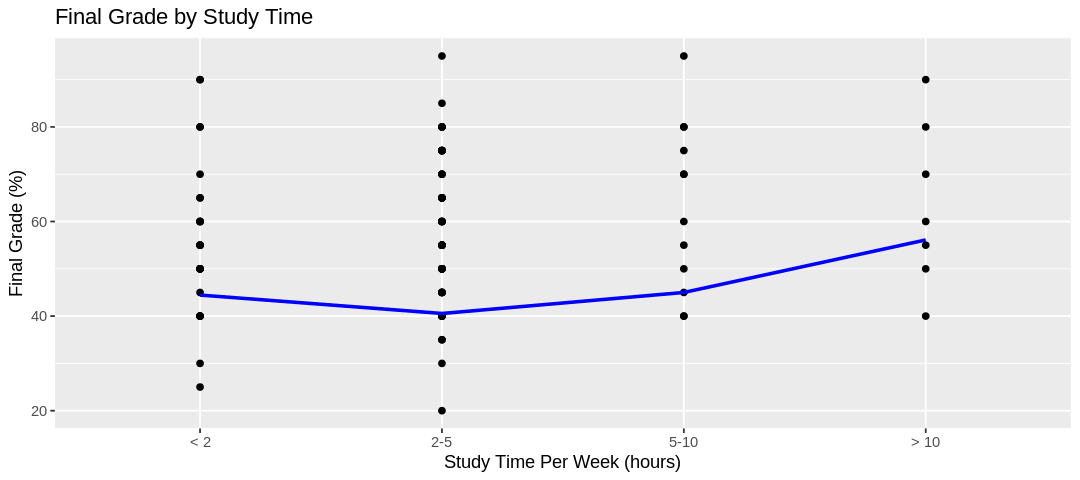

In [28]:
students_plot_studytime

<div style="text-align: center; color: gray;">
    Figure 4.1: Plot of predicted final grade vs. study time.
</div>

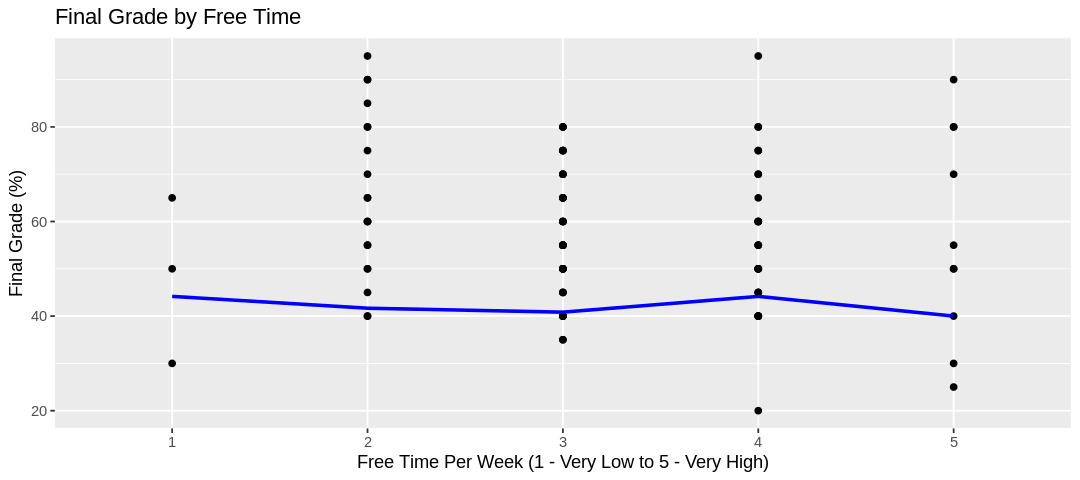

In [29]:
students_plot_freetime

<div style="text-align: center; color: gray;">
    Figure 4.2: Plot of predicted final grade vs. free time.
</div>

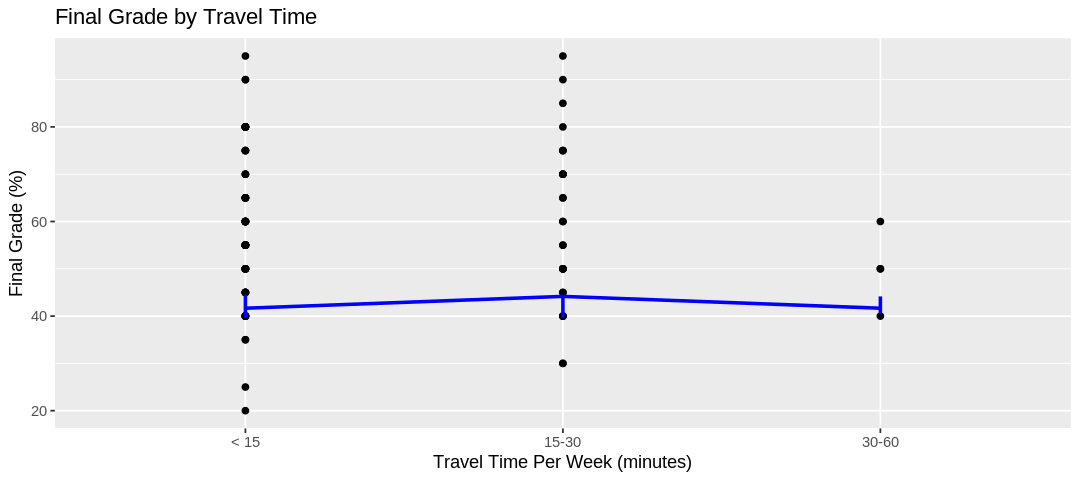

In [30]:
students_plot_traveltime

<div style="text-align: center; color: gray;">
    Figure 4.3: Plot of predicted final grade vs. travel (commute) time.
</div>

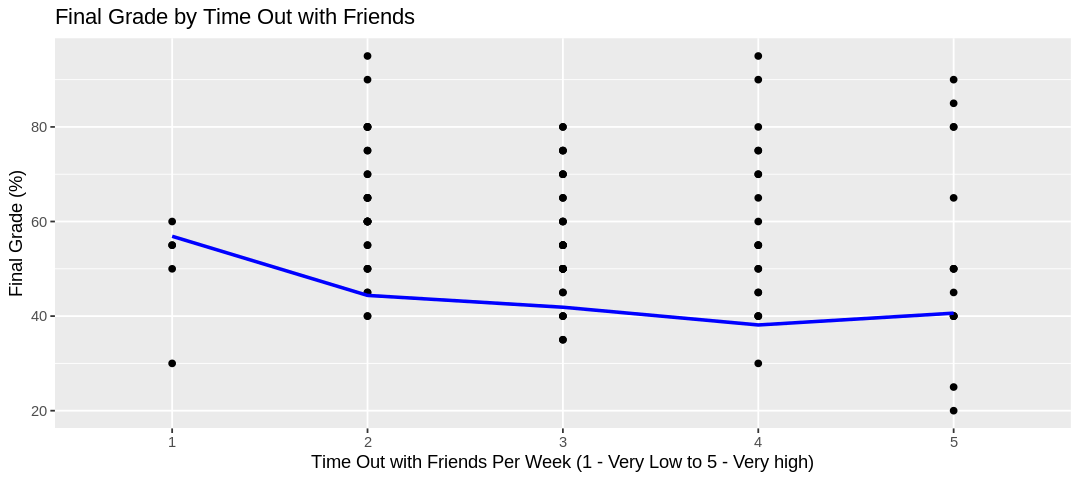

In [31]:
students_plot_goout

<div style="text-align: center; color: gray;">
    Figure 4.4: Plot of predicted final grade vs. time out with friends.
</div>

# Results

<div class="alert alert-warning">
    TODO
</div>

# Discussion

<div class="alert alert-warning">
    TODO
</div>

# References

<div class="alert alert-warning">
    TODO: Find 2 or more sources to use in our report
</div>

> Cortez, Paulo. (2014). Student Performance [Data set]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.